# simple_linear_regression_models

This is an assignment for my thinkful data science course - "simple_linear_regression_models"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/simple_linear_regression_models.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/simple_linear_regression_models.ipynb) - with all the code exposed in an interactive notebook

## House prices dataset

I'm demonstrating a linear regression modeling on a house prices dataset originally from Kaggle. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data): 

The target variable will be the "SalePrice" (the property's sale price in dollars). Since it's a continuous variable, we're dealing with a regression task.


In [87]:
#imports & connection
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [75]:
#db connection
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [76]:
#data load
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


In [77]:
#reset index, head of raw data
houses_df.set_index("id")
houses_df.head()

1460

In [101]:
houses_df.describe()

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,...,5.000000,5.000000,5.000000,5.0,5.0,5.0,5.0,5.00000,5.000000,5.000000
mean,3.000000,54.000000,10622.000000,7.000000,5.600000,1979.000000,1990.200000,608.200000,0.0,379.600000,...,98.000000,44.400000,54.400000,0.0,0.0,0.0,0.0,6.00000,2007.400000,200700.000000
std,1.581139,19.493589,2266.091349,0.707107,1.341641,37.436613,15.880806,281.629544,0.0,160.258541,...,139.326954,31.261798,121.642098,0.0,0.0,0.0,0.0,4.41588,0.894427,42024.695121
min,1.000000,20.000000,8450.000000,6.000000,5.000000,1915.000000,1970.000000,216.000000,0.0,150.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2.00000,2006.000000,140000.000000
25%,2.000000,60.000000,9550.000000,7.000000,5.000000,1976.000000,1976.000000,486.000000,0.0,284.000000,...,0.000000,35.000000,0.000000,0.0,0.0,0.0,0.0,2.00000,2007.000000,181500.000000
50%,3.000000,60.000000,9600.000000,7.000000,5.000000,2000.000000,2000.000000,655.000000,0.0,434.000000,...,0.000000,42.000000,0.000000,0.0,0.0,0.0,0.0,5.00000,2008.000000,208500.000000
75%,4.000000,60.000000,11250.000000,7.000000,5.000000,2001.000000,2002.000000,706.000000,0.0,490.000000,...,192.000000,61.000000,0.000000,0.0,0.0,0.0,0.0,9.00000,2008.000000,223500.000000
max,5.000000,70.000000,14260.000000,8.000000,8.000000,2003.000000,2003.000000,978.000000,0.0,540.000000,...,298.000000,84.000000,272.000000,0.0,0.0,0.0,0.0,12.00000,2008.000000,250000.000000


In [102]:
houses_df.describe(include="O")

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,extercond,foundation,heating,heatingqc,centralair,kitchenqual,functional,paveddrive,saletype,salecondition
count,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
unique,1,1,2,1,1,3,1,4,2,1,...,1,3,1,2,1,2,1,1,1,2
top,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
freq,5,5,3,5,5,2,5,2,4,5,...,5,3,5,4,5,4,5,5,5,4


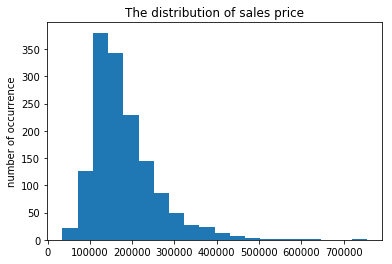

In [79]:
# target variable distribution
plt.hist(houses_df.saleprice, bins=20)
plt.title("The distribution of sales price")
plt.ylabel("number of occurrence")
plt.show()

We observe that sales price is not normally distributed. Instead, it's highly skewed. **Skewness** is a measure of how asymmetric our data is with respect to the normal distribution. As we see in the graph, the sales price variable is not symmetric but skewed to the right. The majority of the observations have low prices and few of the observations have high prices. This makes the distribution of the charges clustered toward the left.

In [81]:
#look for missing values and drop those columns

def remove_null_cols(df):
    n = len(df)
    cols = df.columns
    null_cols = [(len(df[df[col].isnull()]) == 0) for col in df]
    return df.iloc[:, null_cols]
    
houses_df = remove_null_cols(houses_df).head()

In [82]:
#get all the continuous and categorical columns

from itertools import compress

cont_cols = list(compress(houses_df.columns, houses_df.dtypes == int))
cat_cols = list(compress(houses_df.columns, houses_df.dtypes == object))

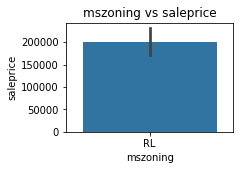

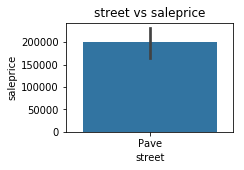

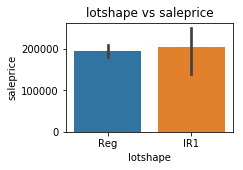

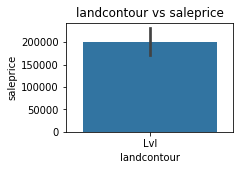

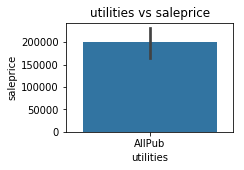

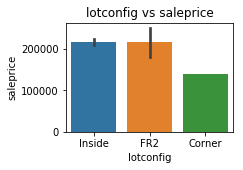

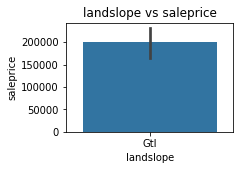

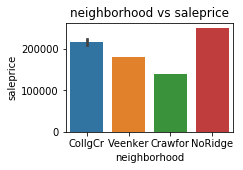

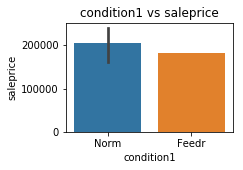

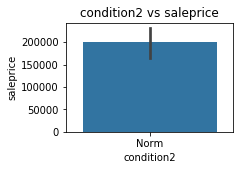

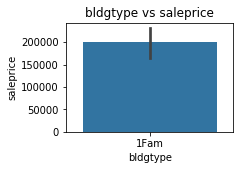

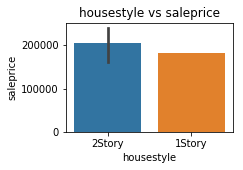

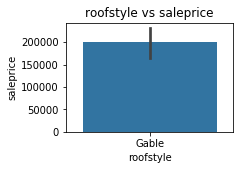

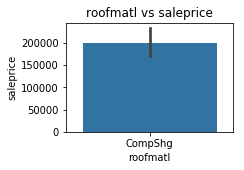

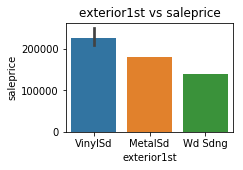

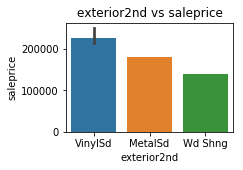

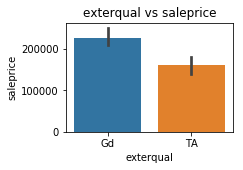

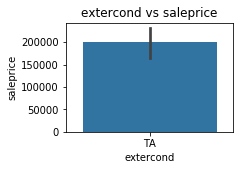

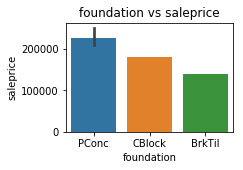

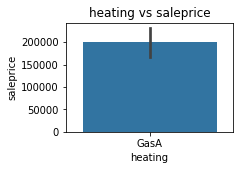

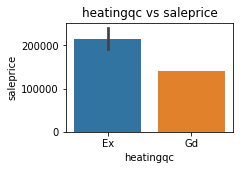

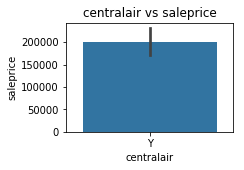

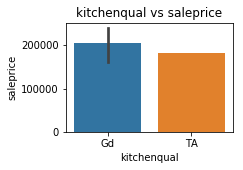

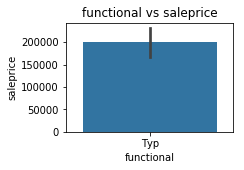

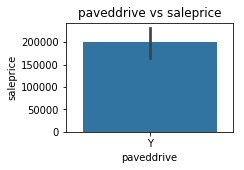

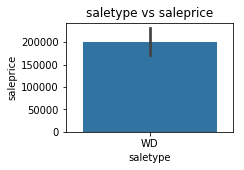

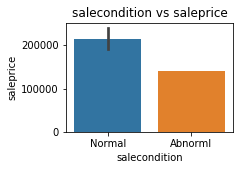

In [88]:
#for catgorical variables - get a visual on which variables split house price

def cat_to_cont(df, cat, cont, threshold):
    """creates a barplot and conducts t-test 
    for a categorical to continuous relationship"""

    #group by
    unique_vals = df[cat].unique()
    grouped_df = df[[cat, cont]].groupby(cat).mean()

    #barplot
    plt.figure(figsize=(3, 2))
    sns.barplot(df[cat], df[cont])
    plt.title("{} vs {}".format(cat, cont))
    plt.show()

    #t-test
    for i in range(0, len(unique_vals)):
        for j in range(i+1, len(unique_vals)):
            t, p = stats.ttest_ind(
                df[df[cat]==unique_vals[i]][cont], 
                df[df[cat]==unique_vals[j]][cont])
            if p < threshold: 
                print("t-test between groups {0} and {1} is significant:  p = {2}:"
                      .format(unique_vals[i], unique_vals[j], p))


for cat in cat_cols: 
    cat_to_cont(houses_df, cat, "saleprice", .05)

In [99]:
#transform the promising categorical variables to one-hot columns and create a features dataframe
neighborhood_df = pd.get_dummies(houses_df.neighborhood, prefix='neighborhood', drop_first=True)
exterior1st_df = pd.get_dummies(houses_df.exterior1st, prefix='exterior1st', drop_first=True)
exterqual_df = pd.get_dummies(houses_df.exterqual, prefix='exterqual', drop_first=True)
foundation_df = pd.get_dummies(houses_df.foundation, prefix='foundation', drop_first=True)
heatingqc_df = pd.get_dummies(houses_df.heatingqc, prefix='heatingqc', drop_first=True)
salecondition_df = pd.get_dummies(houses_df.salecondition, prefix='salecondition', drop_first=True)

features = pd.concat([neighborhood_df, exterior1st_df, exterqual_df, 
                      foundation_df, heatingqc_df, salecondition_df], 
                    axis=1)

# cat_features=["neighborhood_CollgCr","neighborhood_Veenker", "neighborhood_Crawfor", "neighborhood_NoRidge", 
#               "exterior1st_VinylSd", "exterior1st_MetalSd", "exterior1st_Wd Sdng", 
#               "exterqual_Gd", "exterqual_TA", 
#               "foundation_PConc", "foundation_CBlock foundation", "foundation_BrkTil",
#               "heatingqc_Ex", "heatingqc_Gd",
#               "salecondition_Abnorml", "salecondition_Normal"]


features.head()

,neighborhood_Crawfor,neighborhood_NoRidge,neighborhood_Veenker,exterior1st_VinylSd,exterior1st_Wd Sdng,exterqual_TA,foundation_CBlock,foundation_PConc,heatingqc_Gd,salecondition_Normal
0,0,0,0,1,0,0,0,1,0,1
1,0,0,1,0,0,1,1,0,0,1
2,0,0,0,1,0,0,0,1,0,1
3,1,0,0,0,1,1,0,0,1,0
4,0,1,0,1,0,0,0,1,0,1


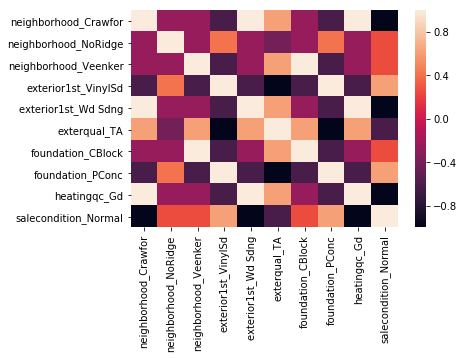

In [104]:
#take a look a the correlation heatmap
sns.heatmap(features.corr())
plt.show()

There are some pretty highligh correlated features.  Let's create a second feature set with some of those removed. 

In [177]:
#find highly correlated feature pairs and remove the one with lowest correlation with sales price
#note I'm pretty sure the pd.DataFrame.corr will work with a catagorical / continuous comparison...
keywords = features.columns
target_corr = {key: abs(houses_df["saleprice"].corr(features[key])) for key in keywords}

correlations = []

for key in keywords: 
    for key2 in keywords: 
        correlations.append((key, key2, abs(features[key].corr(features[key2]))))

print("length of correlations:", len(correlations))
correlations = pd.DataFrame(correlations)
correlations.columns = ["key", "key2", "corr"]
correlations = correlations.sort_values(by="corr", ascending=False)
print("length of correlations:", len(correlations))
correlations["key_target_corr"] = float(0)
correlations["key2_target_corr"] = float(0)
correlations["key2_better"] = False

for i , row in correlations.iterrows():
    correlations.at[i,'key_target_corr'] = target_corr.get(correlations.at[i, "key"])
    correlations.at[i, "key2_target_corr"] = target_corr.get(correlations.at[i, "key2"])
    correlations.at[i, "key2_better"] = correlations.at[i, "key_target_corr"] < correlations.at[i, "key2_target_corr"]
    
keys_to_drop = set(correlations.loc[(correlations["corr"] > .6) & (correlations["key2_better"]==True), "key" ].values)
keywords = set(keywords) - set(keys_to_drop)

features2 = features.drop(keys_to_drop, axis=1)
print("reduced features list:",  features2.columns)
correlations


length of correlations: 100
length of correlations: 100
reduced features list: Index(['neighborhood_NoRidge', 'exterior1st_VinylSd', 'exterqual_TA',
       'foundation_PConc'],
      dtype='object')


,key,key2,corr,key_target_corr,key2_target_corr,key2_better
0,neighborhood_Crawfor,neighborhood_Crawfor,1.000000,0.807438,0.807438,False
26,neighborhood_Veenker,foundation_CBlock,1.000000,0.255400,0.255400,False
35,exterior1st_VinylSd,exterqual_TA,1.000000,0.867804,0.867804,False
37,exterior1st_VinylSd,foundation_PConc,1.000000,0.867804,0.867804,False
40,exterior1st_Wd Sdng,neighborhood_Crawfor,1.000000,0.807438,0.807438,False
44,exterior1st_Wd Sdng,exterior1st_Wd Sdng,1.000000,0.807438,0.807438,False
48,exterior1st_Wd Sdng,heatingqc_Gd,1.000000,0.807438,0.807438,False
49,exterior1st_Wd Sdng,salecondition_Normal,1.000000,0.807438,0.807438,False
53,exterqual_TA,exterior1st_VinylSd,1.000000,0.867804,0.867804,False
55,exterqual_TA,exterqual_TA,1.000000,0.867804,0.867804,False


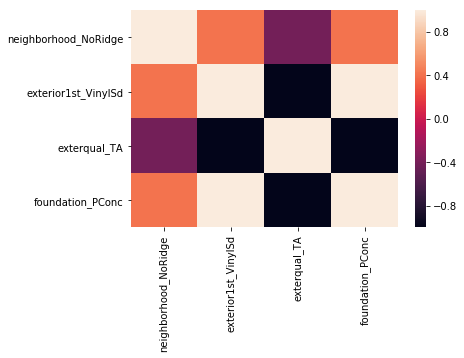

In [179]:
#take a look a the correlation heatmap for the reduced feature set
sns.heatmap(features2.corr())
plt.show()
#for the life of me, can't figure out why it's keeping both sides of a pair with corrleation approaching 1...

## An initial model for home prices

Build a simple linear regression model using all of our promising one-hot features (including some highly-correlated features, and estimate it using OLS. 

In [181]:
# Y is the target variable
Y = houses_df['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = features

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     20.60
Date:                Mon, 27 May 2019   Prob (F-statistic):              0.160
Time:                        17:06:50   Log-Likelihood:                -49.417
No. Observations:                   5   AIC:                             106.8
Df Residuals:                       1   BIC:                             105.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.104e+04   2112.085     33.634      0.019    4.42e+04    9.79e+04
neighborhood_Crawfor  1.396e+04   2707.475      5.154      0.122   -2.04e+04    4.84e+04
neighborhood_NoRidge    3.4e+04    1.3e+04      2.617      0.232   -1.31e+05    1.99e+05
neighborhood_Veenker  1.314e+04   3278.915      4.008      0.156   -2.85e+04    5.48e+04
exterior1st_VinylSd   4.394e+04   2674.881     16.427      0.039    9952.709    7.79e+04
exterior1st_Wd Sdng   1.396e+04   2707.475      5.154      0.122   -2.04e+04    4.84e+04
exterqual_TA           2.71e+04   2785.042      9.729      0.065   -8290.302    6.25e+04
foundation_CBlock     1.314e+04   3278.915      4.008      0.156   -2.85e+04    5.48e+04
foundation_PConc      4.394e+04   2674.881     16.427      0.039    9952.709    7.79e+04
heatingqc_Gd          1.396e+04   2707.475      5.154      0.122   -2.04e+04    4.84e+04
salecondition_Normal  5.708e+04   2525.488     22.602      0.028     2.5e+04    8.92e+04
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.500
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.052
Skew:                          -0.000   Prob(JB):                        0.974
Kurtosis:                       2.500   Cond. No.                     3.84e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The smallest eigenvalue is 9.7e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## A model with the reduced features set

This one is build with fewer features - i.e. removing some that were correlated with others.  

In [182]:
# Y is the target variable
Y = houses_df['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = features2

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     6.256
Date:                Mon, 27 May 2019   Prob (F-statistic):              0.138
Time:                        17:06:52   Log-Likelihood:                -54.812
No. Observations:                   5   AIC:                             115.6
Df Residuals:                       2   BIC:                             114.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.075e+05   6977.195     15.407      0.004    7.75e+04    1.38e+05
neighborhood_NoRidge    3.4e+04    2.7e+04      1.258      0.335   -8.23e+04     1.5e+05
exterior1st_VinylSd   5.425e+04   6977.195      7.775      0.016    2.42e+04    8.43e+04
exterqual_TA          5.325e+04   9867.244      5.397      0.033    1.08e+04    9.57e+04
foundation_PConc      5.425e+04   6977.195      7.775      0.016    2.42e+04    8.43e+04
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.262
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.213
Skew:                          -0.000   Prob(JB):                        0.899
Kurtosis:                       1.989   Cond. No.                     1.83e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.09e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""